# Transfer Learning with Tensorflow : Feature Extraction

Leveraging a working model's existing architecture and learned patter for our own problem.

benefits :
1. can leverage an existing neural network architecture proven to work on problem similar to our own
2. can leverage a woking NN architecture which has already learned pattern on similar data to our own, can be adapted those pattern to our data.

In [2]:
!nvidia-smi

Sun May 23 09:56:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip #only contains 10% of our original data, if we train our own model with this amount of data, it most likely to perform worse than our latest model, acc : 40%

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2021-05-23 09:56:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  11.0MB/s    in 17s     

2021-05-23 09:56:29 (9.50 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_shape = (224,224)
batch_size = 32

traindir = '10_food_classes_10_percent/train/'
testdir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/225.)
test_datagen = ImageDataGenerator(rescale=1/225.)

train_data_10_percent = train_datagen.flow_from_directory(traindir,
                                                          target_size = image_shape,
                                                          batch_size = batch_size,
                                                          class_mode = 'categorical')

test_data = train_datagen.flow_from_directory(testdir,
                                                          target_size = image_shape,
                                                          batch_size = batch_size,
                                                          class_mode = 'categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# setting up callbacks (things to run whilst our model trains)

callbacks are extra function you can add to models to be performed during or after training. some popular callbacks :

* Tracking with TensorBoard
* Model checkpoint with the modelCheckpoint to save model at some point
* Early stopping to stop training when metric stops improving

In [6]:
# TensorBoard Callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  return tensorboard_callback

becauase we are mostlikely to run multiple experiment, its good idead to be able to track them.

our function saves model performance in directory named [dir_name]/[experiment_name]/[current_timestamp], where:

- dir_name is the overall logs directory
- experiment_name is the particular experiment
- current_timestamp is the time the experiment started based on Python's datetime.datetime().now()

# Creating models uising tensorflow hub

instead building model and training from scratch, we are going to use existing model from tensorflow hub, for example : ResNetV2, EfficientNet, MobileNet, many more, explore tfhub.dev.

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# EfficientNet0 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [15]:
def buildmodel(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns, so we dont change any parameter on the model
                                           name='feature_extraction_layer',
                                           input_shape=image_shape+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

now we have function to instiate model, lets build it

In [17]:
# Create model
resnetmodel = buildmodel(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnetmodel.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fitting Model

In [20]:
resnethistory = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Epoch 1/5
24/24 [==============================] - 59s 1s/step - loss: 2.5209 - accuracy: 0.1754 - val_loss: 1.3579 - val_accuracy: 0.5564
Epoch 2/5
24/24 [==============================] - 21s 906ms/step - loss: 1.1111 - accuracy: 0.6546 - val_loss: 0.8947 - val_accuracy: 0.7252
Epoch 3/5
24/24 [==============================] - 21s 907ms/step - loss: 0.7052 - accuracy: 0.8088 - val_loss: 0.7665 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 21s 901ms/step - loss: 0.5522 - accuracy: 0.8569 - val_loss: 0.7254 - val_accuracy: 0.7756
Epoch 5/5
24/24 [==============================] - 21s 908ms/step - loss: 0.3884 - accuracy: 0.9088 - val_loss: 0.7020 - val_accuracy: 0.7748


with only 5 epochs and only 10% of our data, the model achieved 90% on trainset and 77% on test set, much better than any model we created before.

In [21]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plotcurves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

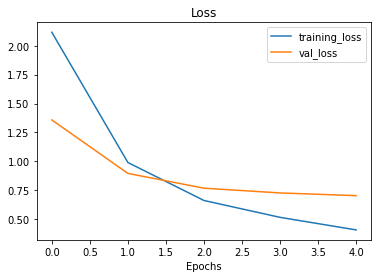

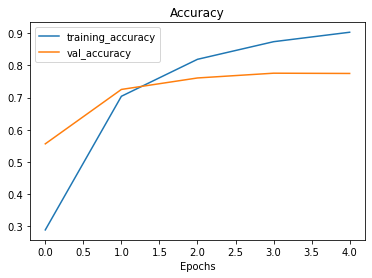

In [22]:
plotcurves(resnethistory)

lets try using efficientnet

In [23]:
# Create model
efficientnetmodel = buildmodel(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnetmodel.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnethistory = efficientnetmodel.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Epoch 1/5
24/24 [==============================] - 33s 988ms/step - loss: 2.1114 - accuracy: 0.2695 - val_loss: 1.3299 - val_accuracy: 0.7108
Epoch 2/5
24/24 [==============================] - 19s 824ms/step - loss: 1.1883 - accuracy: 0.7641 - val_loss: 0.9001 - val_accuracy: 0.8084
Epoch 3/5
24/24 [==============================] - 19s 814ms/step - loss: 0.8384 - accuracy: 0.8165 - val_loss: 0.7298 - val_accuracy: 0.8308
Epoch 4/5
24/24 [==============================] - 19s 810ms/step - loss: 0.6344 - accuracy: 0.8627 - val_loss: 0.6405 - val_accuracy: 0.8444
Epoch 5/5
24/24 [==============================] - 19s 809ms/step - loss: 0.5618 - accuracy: 0.8742 - val_loss: 0.5874 - val_accuracy: 0.8536


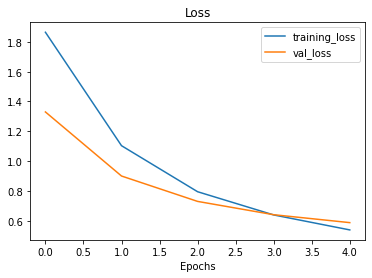

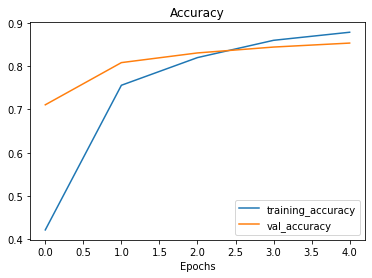

In [24]:
plotcurves(efficientnethistory)

even better, remember we only use 10% of our data, imagine if we use all the data we have, train for longer.

In [25]:
resnetmodel.evaluate(test_data)
efficientnetmodel.evaluate(test_data)

79/79 [==============================] - 15s 188ms/step - loss: 0.5874 - accuracy: 0.8536


[0.5873734951019287, 0.853600025177002]

## Types of transfer learning

- 'As is' : No change whjat so ever
- 'Feature Extraction' : use preleared pattern of existing model, and adjusting it by adding layer after it(efficientnet trained on 1000 classes, we only use 10)
- 'Fine-Tune' : use prelearned patter of existing model and 'fine-tune' the underlying layers

# Comparing Model

we could compare the two models just by looking at the performance they output, but what if we have more than 2? say 5 or so, this is where we use TensorBoard to track it.

In [26]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2021-05-23 10:34:26.770648: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

[this is our experiment](https://tensorboard.dev/experiment/RdIZB907T2uJnS5u4SAYBw/)

In [27]:
# Check out experiments
!tensorboard dev list

2021-05-23 10:37:22.102855: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/RdIZB907T2uJnS5u4SAYBw/
	Name                 [No Name]
	Description          [No Description]
	Id                   RdIZB907T2uJnS5u4SAYBw
	Created              2021-05-23 10:35:33 (1 minute ago)
	Updated              2021-05-23 10:35:37 (1 minute ago)
	Runs                 4
	Tags                 3
	Scalars              40
	Tensor bytes         0
	Binary object bytes  6020426
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id id_here